In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [2]:
path = '/work/slavov/JD/lib_prediction/report-lib_017_18_19.tsv'
df = pd.read_csv(path, delimiter='\t')
original_df = pd.DataFrame(df)
distinct_df = original_df.drop_duplicates(subset='transition_group_id') #we don't need fragments for iRT prediction

distinct_df

,FileName,PrecursorMz,ProductMz,Tr_recalibrated,IonMobility,transition_name,LibraryIntensity,transition_group_id,decoy,PeptideSequence,...,PrecursorCharge,PeptideGroupLabel,UniprotID,NTerm,CTerm,FragmentType,FragmentCharge,FragmentSeriesNumber,FragmentLossType,ExcludeFromAssay
0,\\PTI\Lab\RawData\E240\JD0018.raw,1269.13660,948.49084,30.399069,0,(mTRAQ)AAAAAAAAAGGDAGHAPFPPPPAADGAR2_121_1_0_18,1.0,(mTRAQ)AAAAAAAAAGGDAGHAPFPPPPAADGAR2,0,AAAAAAAAAGGDAGHAPFPPPPAADGAR,...,2,(mTRAQ)AAAAAAAAAGGDAGHAPFPPPPAADGAR,Q8N319,0,0,y,1,10,noloss,True
12,\\PTI\Lab\RawData\E240\JD0018.raw,846.42706,1192.61210,30.529606,0,(mTRAQ)AAAAAAAAAGGDAGHAPFPPPPAADGAR3_121_1_0_16,1.0,(mTRAQ)AAAAAAAAAGGDAGHAPFPPPPAADGAR3,0,AAAAAAAAAGGDAGHAPFPPPPAADGAR,...,3,(mTRAQ)AAAAAAAAAGGDAGHAPFPPPPAADGAR,Q8N319,0,0,y,1,12,noloss,True
24,\\PTI\Lab\RawData\E240\JD0018.raw,635.07227,754.38531,30.489227,0,(mTRAQ)AAAAAAAAAGGDAGHAPFPPPPAADGAR4_121_1_0_20,1.0,(mTRAQ)AAAAAAAAAGGDAGHAPFPPPPAADGAR4,0,AAAAAAAAAGGDAGHAPFPPPPAADGAR,...,4,(mTRAQ)AAAAAAAAAGGDAGHAPFPPPPAADGAR,Q8N319,0,0,y,1,8,noloss,True
36,\\PTI\Lab\RawData\E240\JD0018.raw,1236.74340,638.36255,8.972691,0,(mTRAQ)AAAAAAALQAK(mTRAQ)1_98_1_0_7,1.0,(mTRAQ)AAAAAAALQAK(mTRAQ)1,0,AAAAAAALQAK,...,1,(mTRAQ)AAAAAAALQAK(mTRAQ),P36578,0,0,b,1,7,noloss,False
48,\\PTI\Lab\RawData\E240\JD0018.raw,618.87561,425.25125,8.891004,0,(mTRAQ)AAAAAAALQAK(mTRAQ)2_98_1_0_4,1.0,(mTRAQ)AAAAAAALQAK(mTRAQ)2,0,AAAAAAALQAK,...,2,(mTRAQ)AAAAAAALQAK(mTRAQ),P36578,0,0,b,1,4,noloss,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1893504,\\PTI\Lab\RawData\E240\JD0018.raw,386.96164,466.25317,42.038303,0,(mTRAQ)YYVTIIDAPGHR4_121_1_0_8,1.0,(mTRAQ)YYVTIIDAPGHR4,0,YYVTIIDAPGHR,...,4,(mTRAQ)YYVTIIDAPGHR,P68104;Q5VTE0,0,0,y,1,4,noloss,True
1893516,\\PTI\Lab\RawData\E240\JD0018.raw,1074.50220,701.32983,36.950443,0,(mTRAQ)YYYAVVDC(UniMod:4)DSPETASK(mTRAQ)2_98_1...,1.0,(mTRAQ)YYYAVVDC(UniMod:4)DSPETASK(mTRAQ)2,0,YYYAVVDCDSPETASK,...,2,(mTRAQ)YYYAVVDC(UniMod:4)DSPETASK(mTRAQ),Q9H501,0,0,b,1,4,noloss,False
1893528,\\PTI\Lab\RawData\E240\JD0018.raw,716.67072,701.32983,36.911182,0,(mTRAQ)YYYAVVDC(UniMod:4)DSPETASK(mTRAQ)3_98_1...,1.0,(mTRAQ)YYYAVVDC(UniMod:4)DSPETASK(mTRAQ)3,0,YYYAVVDCDSPETASK,...,3,(mTRAQ)YYYAVVDC(UniMod:4)DSPETASK(mTRAQ),Q9H501,0,0,b,1,4,noloss,False
1893540,\\PTI\Lab\RawData\E240\JD0018.raw,709.38019,675.38354,41.082706,0,(mTRAQ)YYYIPQYK(mTRAQ)2_121_1_0_4,1.0,(mTRAQ)YYYIPQYK(mTRAQ)2,0,YYYIPQYK,...,2,(mTRAQ)YYYIPQYK(mTRAQ),Q8N183,0,0,y,1,4,noloss,False


In [3]:

peptide_sequence = "ACDEFGHIKLMNPQRSTVWY"   #all possible amino acids
max_sequence_length = 30    
num_amino_acids = 20      #possible amino acids

#amino acid index map
amino_acid_to_index = {aa: i for i, aa in enumerate(peptide_sequence)}

def one_hot_encode_sequence(sequence):
    one_hot_sequence = np.zeros((max_sequence_length, num_amino_acids), dtype=np.float32)
    for i, aa in enumerate(sequence[:max_sequence_length]):
        aa_index = amino_acid_to_index.get(aa.upper(), None)
        if aa_index is not None:
            one_hot_sequence[i, aa_index] = 1.0
    return one_hot_sequence

#compute the average RT for each peptide sequence (average of the different charge states)
grouped_df = distinct_df.groupby('PeptideSequence', as_index=False).agg({
    'Tr_recalibrated': 'mean'
})

#onehot encode the peptide sequence
X_peptide = [one_hot_encode_sequence(seq) for seq in grouped_df['PeptideSequence']]

X = np.array(X_peptide)
Y = grouped_df['Tr_recalibrated'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=123)

print(f"Training data size: {X_train.shape}, Test data size: {X_test.shape}")

Training data size: (56645, 30, 20), Test data size: (6294, 30, 20)


In [4]:
grouped_df['PeptideSequence'][1]

'AAAAAAALQAK'

In [5]:
X_peptide[1]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.

In [6]:
X[1]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.

Training model 1/5
Epoch 1/150
1594/1594 [==============================] - 20s 11ms/step - loss: 6.8647 - val_loss: 6.7887
Epoch 2/150
1594/1594 [==============================] - 17s 11ms/step - loss: 4.1655 - val_loss: 3.4394
Epoch 3/150
1594/1594 [==============================] - 17s 11ms/step - loss: 3.4904 - val_loss: 3.3509
Epoch 4/150
1594/1594 [==============================] - 18s 11ms/step - loss: 3.1599 - val_loss: 2.9074
Epoch 5/150
1594/1594 [==============================] - 17s 11ms/step - loss: 2.9757 - val_loss: 3.0736
Epoch 6/150
1594/1594 [==============================] - 17s 11ms/step - loss: 2.7098 - val_loss: 3.3068
Epoch 7/150
1594/1594 [==============================] - 17s 11ms/step - loss: 2.6691 - val_loss: 3.1755
Epoch 8/150
1594/1594 [==============================] - 18s 11ms/step - loss: 2.5416 - val_loss: 2.7732
Epoch 9/150
1594/1594 [==============================] - 18s 11ms/step - loss: 2.4136 - val_loss: 2.2126
Epoch 10/150
1594/1594 [============

INFO:tensorflow:Assets written to: iRT_CNN_model_mTRAQ_09182024_0/assets


INFO:tensorflow:Assets written to: iRT_CNN_model_mTRAQ_09182024_1/assets


INFO:tensorflow:Assets written to: iRT_CNN_model_mTRAQ_09182024_1/assets


INFO:tensorflow:Assets written to: iRT_CNN_model_mTRAQ_09182024_2/assets


INFO:tensorflow:Assets written to: iRT_CNN_model_mTRAQ_09182024_2/assets


INFO:tensorflow:Assets written to: iRT_CNN_model_mTRAQ_09182024_3/assets


INFO:tensorflow:Assets written to: iRT_CNN_model_mTRAQ_09182024_3/assets


INFO:tensorflow:Assets written to: iRT_CNN_model_mTRAQ_09182024_4/assets


INFO:tensorflow:Assets written to: iRT_CNN_model_mTRAQ_09182024_4/assets


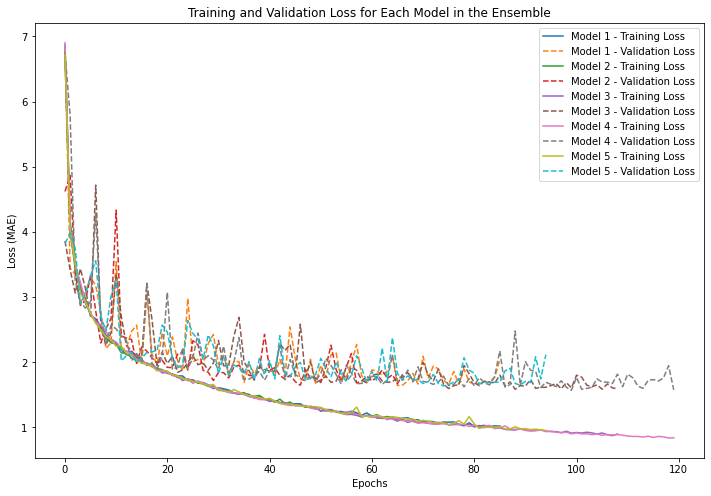

In [11]:
import tensorflow as tf
import numpy as np
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

seed_value = 123
tf.random.set_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)

def build_model():
    model = Sequential()
    
    model.add(Conv1D(filters=32, kernel_size=4, activation='swish', padding='same'))
    model.add(MaxPooling1D(pool_size=1))

    model.add(Conv1D(filters=64, kernel_size=4, activation='swish', padding='same'))
    model.add(MaxPooling1D(pool_size=1))

    model.add(Conv1D(filters=128, kernel_size=4, activation='swish', padding='same'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(filters=256, kernel_size=4, activation='swish', padding='same'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Flatten())

    # feed into dense layers
    model.add(Dense(1000, activation='swish'))
    model.add(Dense(256, activation='swish'))
    model.add(Dense(128, activation='swish'))
    model.add(Dense(64, activation='swish'))
    model.add(Dense(32, activation='swish'))

    model.add(Dense(1, activation='linear')) #this is the retention time (RT) output

    adam_optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=adam_optimizer, loss='mae')
    
    return model

# create an ensemble of 5 models.. this slightly helps and is probably worth the extra bit of time.
ensemble_size = 5
ensemble_models = []
history_list = []

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

for i in range(ensemble_size):
    print(f"Training model {i+1}/{ensemble_size}")
    model = build_model()
    history = model.fit(X_train, Y_train, epochs=150, batch_size=32, validation_split=0.1, callbacks=[early_stopping])
    ensemble_models.append(model)
    history_list.append(history.history)

# evaluate each model 
test_losses = []
for i, model in enumerate(ensemble_models):
    print(f"Evaluating model {i+1}/{ensemble_size}")
    test_loss = model.evaluate(X_test, Y_test)
    test_losses.append(test_loss)
    print(f"Test loss for model {i+1}: {test_loss}")

#average predictions
predictions = np.zeros_like(Y_test)
for model in ensemble_models:
    predictions += model.predict(X_test).flatten()

predictions /= ensemble_size

ensemble_loss = np.mean(np.abs(predictions - Y_test))  #MAE for the ensemble
print(f"Ensemble test loss (MAE): {ensemble_loss}")

for i, model in enumerate(ensemble_models):
    model.save(f'iRT_CNN_model_mTRAQ_09182024_{i}')

plt.figure(figsize=(12, 8))
for i, history in enumerate(history_list):
    plt.plot(history['loss'], label=f'Model {i+1} - Training Loss')
    plt.plot(history['val_loss'], label=f'Model {i+1} - Validation Loss', linestyle='--')

plt.title('Training and Validation Loss for Each Model in the Ensemble')
plt.xlabel('Epochs')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.show()




In [11]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import r2_score

# Define model names
model_names = [f"iRT_CNN_model_mTRAQ_09182024_{i}" for i in range(5)]

# Load saved models
ensemble_models = [tf.keras.models.load_model(name) for name in model_names]

# Ensure test data is in NumPy format
X_test = np.array(X_test)
Y_test = np.array(Y_test)

# Calculate R-squared for each model
r2_scores = {}
for i, model in enumerate(ensemble_models):
    model_name = model_names[i]
    predictions = model.predict(X_test).flatten()  # Ensure 1D array
    r2_scores[model_name] = r2_score(Y_test, predictions)
    print(f'R-squared ({model_name}): {r2_scores[model_name]:.4f}')

# Calculate ensemble mean prediction
predictions = np.array([model.predict(X_test).flatten() for model in ensemble_models])
mean_prediction = np.mean(predictions, axis=0)

# Calculate R-squared for ensemble
r2_ensemble = r2_score(Y_test, mean_prediction)
print(f"\nR-squared (Ensemble): {r2_ensemble:.4f}")



197/197 [==============================] - 1s 4ms/step
R-squared (iRT_CNN_model_mTRAQ_09182024_0): 0.9967
197/197 [==============================] - 1s 4ms/step
R-squared (iRT_CNN_model_mTRAQ_09182024_1): 0.9965
197/197 [==============================] - 1s 4ms/step
R-squared (iRT_CNN_model_mTRAQ_09182024_2): 0.9970
197/197 [==============================] - 1s 4ms/step
R-squared (iRT_CNN_model_mTRAQ_09182024_3): 0.9970
197/197 [==============================] - 1s 4ms/step
R-squared (iRT_CNN_model_mTRAQ_09182024_4): 0.9967
197/197 [==============================] - 1s 4ms/step

R-squared (Ensemble): 0.9978


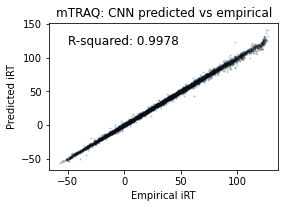

In [18]:

plt.figure(figsize=(4.1, 2.7))
plt.scatter(Y_test, mean_prediction, alpha=0.2, marker='o', edgecolor='k',s=1)
plt.xlabel('Empirical iRT')
plt.ylabel('Predicted iRT')
plt.title('mTRAQ: CNN predicted vs empirical')
plt.text(-50, 120, f"R-squared: {r2_ensemble:.4f}", fontsize = 12)

plt.savefig('pred_vs_emp_plot_CNN.pdf',dpi=400)

plt.show()


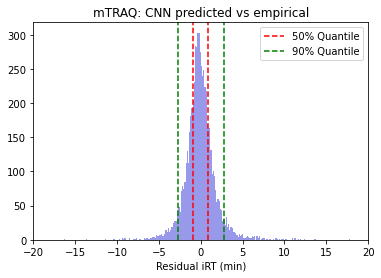

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# residuals (empirical - predicted)
residuals = Y_test - mean_prediction.squeeze()

absolute_deviation = np.abs(residuals)

# 50% and 90% quantiles
quantile_50 = np.quantile(absolute_deviation, 0.50)
quantile_95 = np.quantile(absolute_deviation, 0.90)

plt.figure(figsize=(6, 4))
plt.xlim(-20, 20)
plt.hist(residuals, bins=300, color='mediumblue', alpha=0.4)
plt.xlabel('Residual iRT (min)')
plt.title('mTRAQ: CNN predicted vs empirical')

plt.axvline(-quantile_50, color='red', linestyle='--')
plt.axvline(quantile_50, color='red', linestyle='--', label='50% Quantile')
plt.axvline(-quantile_95, color='green', linestyle='--')
plt.axvline(quantile_95, color='green', linestyle='--', label='90% Quantile')
plt.legend()
plt.savefig('residuals_plot_CNN.png', dpi=400)

